# Практическая работа «Кластеризация. Метод k-средних»

## Цель практической работы

- Научиться строить модель кластеризации на реальных данных.

## Что входит в работу


- Загрузить данные и провести разведочный анализ.
- Предположить оптимальное количество кластеров.
- Построить модель кластеризации с помощью  библиотеки scikit-learn.
- Вычислить оптимальное количество кластеров.
- Интерпретировать результаты.

## Что оценивается

*   Выполнены все этапы задания.
*   Сделаны выводы по результатам.

## Как отправить работу на проверку

Скачайте файл с заданием в материалах, откройте его через Jupyter Notebook и выполните задачи. Сохраните изменения при помощи опции Save and Checkpoint из вкладки меню File или кнопки Save and Checkpoint на панели инструментов. Отправьте через форму ниже итоговый файл Jupyter Notebook (с расширением .ipynb) или ссылку на него.


## Задача

Пусть имеется набор данных `Mall_Customers.csv` о покупателях супермаркета:

* CustomerID — идентификатор покупателя;
* Genre — пол;
* Age — возраст;
* Annual Income (k$) — годовой доход покупателя в тыс. долл.;
* Spending Score (1–100) — рейтинг трат покупателя.

Решите задачу кластеризации покупателей, чтобы в дальнейшем планировать маркетинговые акции для каждой группы.

#### Библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

### Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других обнаруженных свойствах данных.

In [2]:
df = pd.read_csv('data/Mall_Customers.csv')
df_to_interprit = df.copy()
print(df.shape)
df.head(5)

(200, 5)


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
# Получаем количество пропусков
missing_values = df.isna().sum()
# Получаем процент пропусков
missing_percentage = (missing_values / df.shape[0]) * 100
# Объединяем в один DataFrame
missing_info = pd.DataFrame({
    'Количество пропусков': missing_values,
    'Процент пропусков': missing_percentage
})
# Создаем переменную с пропусками
missing_info = missing_info[missing_info['Количество пропусков'] > 0]
print(missing_info)

Empty DataFrame
Columns: [Количество пропусков, Процент пропусков]
Index: []


In [4]:
def calculate_iqr_boundaries(series):
  q25 = series.quantile(0.25)
  q75 = series.quantile(0.75)
  iqr = q75 - q25

  boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
  return boundaries

In [5]:
df['Genre'].value_counts()

Genre
Female    112
Male       88
Name: count, dtype: int64

------- Age -------
Размах (-1.625, 79.375)
Количество выбросов 0 0


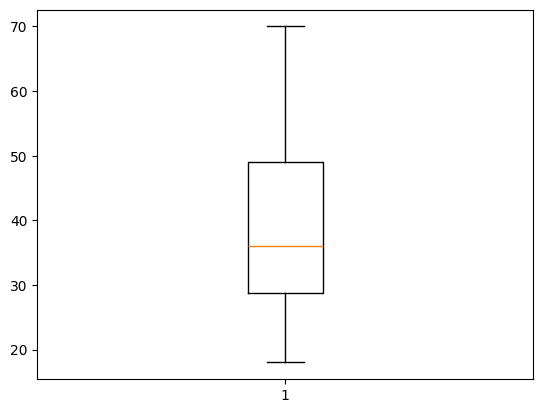

count    200.000000
mean      38.850000
std       13.969007
min       18.000000
25%       28.750000
50%       36.000000
75%       49.000000
max       70.000000
Name: Age, dtype: float64
=======+++++++=======
------- Annual Income (k$) -------
Размах (-13.25, 132.75)
Количество выбросов 0 2


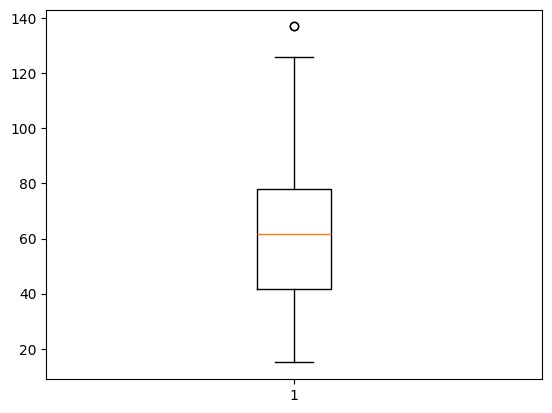

count    200.000000
mean      60.560000
std       26.264721
min       15.000000
25%       41.500000
50%       61.500000
75%       78.000000
max      137.000000
Name: Annual Income (k$), dtype: float64
=======+++++++=======
------- Spending Score (1-100) -------
Размах (-22.625, 130.375)
Количество выбросов 0 0


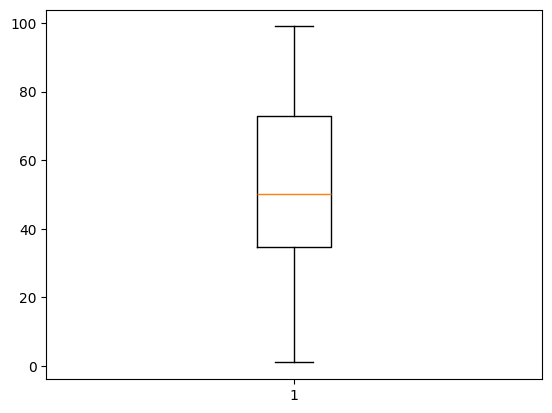

count    200.000000
mean      50.200000
std       25.823522
min        1.000000
25%       34.750000
50%       50.000000
75%       73.000000
max       99.000000
Name: Spending Score (1-100), dtype: float64
=======+++++++=======


In [6]:
num_cols = df.select_dtypes(include=['number']).drop(['CustomerID'], axis=1)
num_cols_list = num_cols.columns
for i in num_cols_list:
    bounds = calculate_iqr_boundaries(df[i])
    out_l = sum(df[i] < bounds[0])
    out_r = sum(df[i] > bounds[1])
    print('-------', i, '-------')
    print('Размах', bounds)
    print('Количество выбросов', out_l, out_r)
    plt.boxplot(df[i])
    plt.show()
    print(df[i].describe())
    print('=======+++++++=======')

<Axes: >

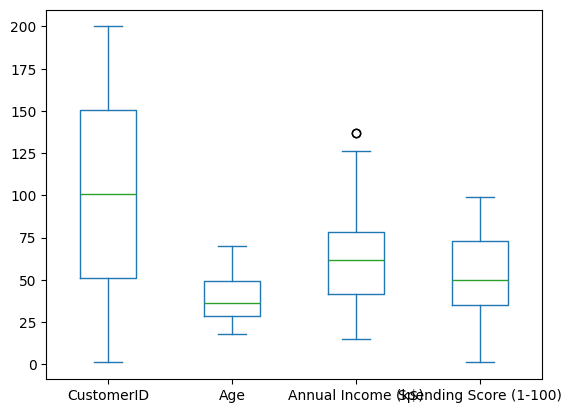

In [7]:
df.plot(kind='box')

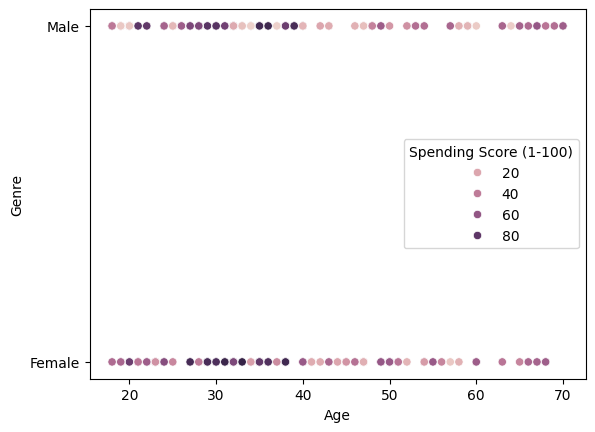

In [8]:
sns.scatterplot(data=df, x='Age', y='Genre', hue='Spending Score (1-100)');

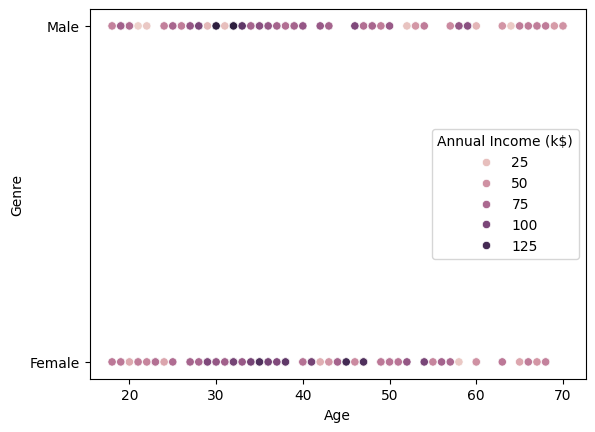

In [9]:
sns.scatterplot(data=df, x='Age', y='Genre', hue='Annual Income (k$)');

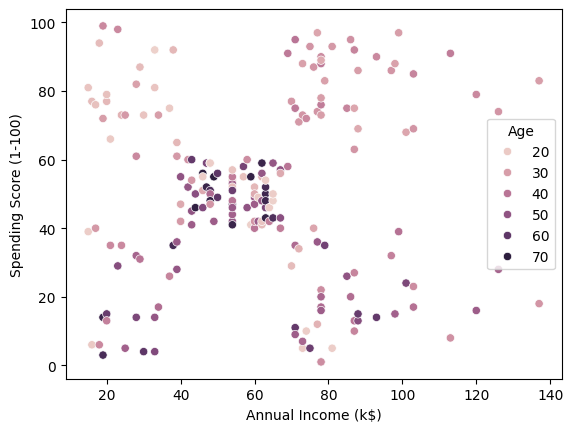

In [10]:
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Age');

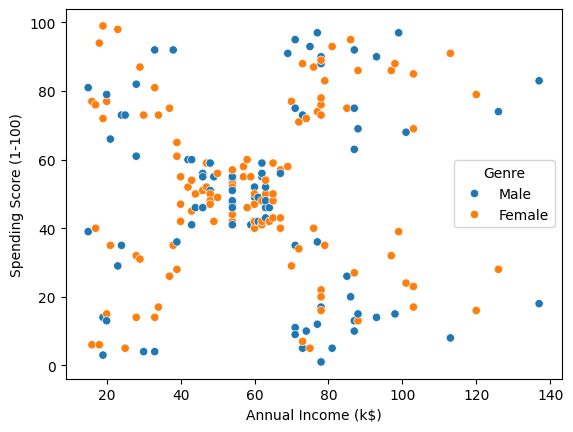

In [11]:
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Genre');

### Задание 2

Метод k-средних требует явно задать количество кластеров, на которые будут разбиваться данные. Поскольку данных может быть настолько много, что построение одной модели будет занимать несколько часов, важно примерно оценить количество кластеров до запуска обучения модели.

На основе результатов разведочного анализа данных предположите, какое количество кластеров будет оптимальным, и аргументируйте предположение.

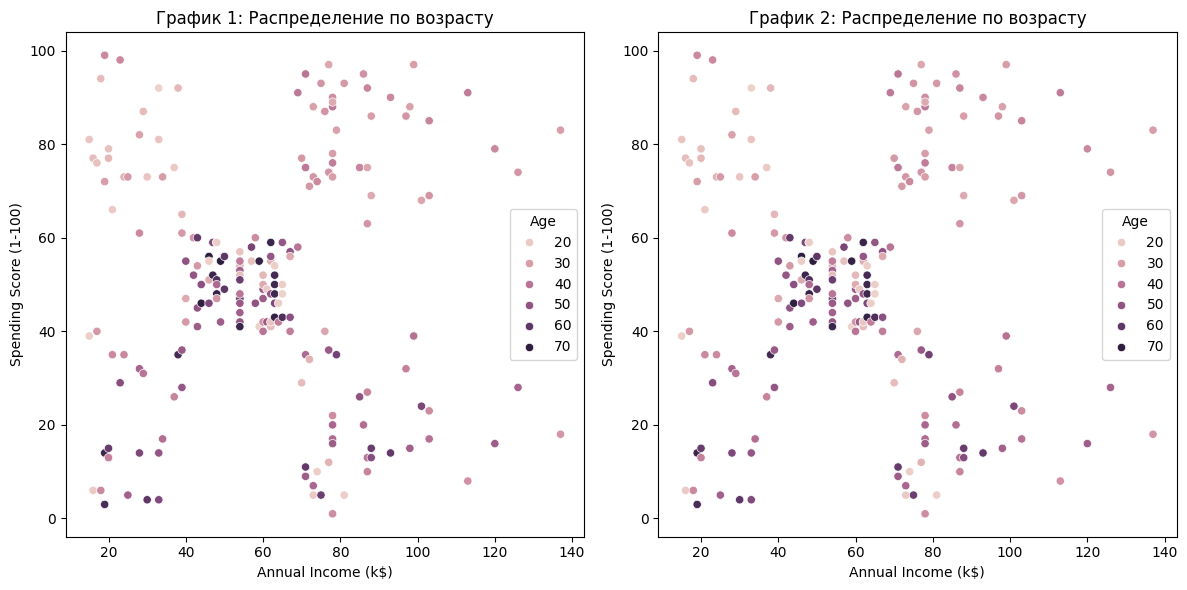

In [12]:
# Настройка фигуры с двумя подграфиками
plt.figure(figsize=(12, 6))

# Первый график
plt.subplot(1, 2, 1)  # 1 строка, 2 колонки, 1 график
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Age')
plt.title('График 1: Распределение по возрасту')

# Второй график
plt.subplot(1, 2, 2)  # 1 строка, 2 колонки, 2 график
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Age')
plt.title('График 2: Распределение по возрасту')

# Отображение графиков
plt.tight_layout()  # Автоматическая настройка расстояний между подграфиками
plt.show()

In [13]:
# Исходя из графиков предположим наличие пяти кластеров

### Задание 3

Преобразуйте категориальный признак Genre в численный. Аргументируйте выбор метода кодирования признака.

In [14]:
# OneHotEycoder с параметром drop_first даст отличный бинарный признак

In [15]:
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
encoded_genre = encoder.fit_transform(df[['Genre']])

# Преобразование результата обратно в DataFrame
encoded_genre_df = pd.DataFrame(encoded_genre, columns=encoder.get_feature_names_out(['Genre']))

# Сброс индексов
df.reset_index(drop=True, inplace=True)
encoded_genre_df.reset_index(drop=True, inplace=True)

# Объединение с сбросом индексов
df_encoded = pd.concat([df, encoded_genre_df], axis=1)

# Удаление оригинального столбца 'Genre', если это нужно
df_encoded = df_encoded.drop(columns=['Genre'])

print(df_encoded)

     CustomerID  Age  Annual Income (k$)  Spending Score (1-100)  Genre_Male
0             1   19                  15                      39         1.0
1             2   21                  15                      81         1.0
2             3   20                  16                       6         0.0
3             4   23                  16                      77         0.0
4             5   31                  17                      40         0.0
..          ...  ...                 ...                     ...         ...
195         196   35                 120                      79         0.0
196         197   45                 126                      28         0.0
197         198   32                 126                      74         1.0
198         199   32                 137                      18         1.0
199         200   30                 137                      83         1.0

[200 rows x 5 columns]


### Задание 4

Постройте модель кластеризации с помощью метода k-средних. Определите оптимальное количество кластеров с помощью метода локтя.

In [16]:
df_id_out = df_encoded.drop(['CustomerID'], axis=1)
df_an_sp = df_encoded[['Annual Income (k$)', 'Spending Score (1-100)']]

# сократим количество данных до ['Annual Income (k$)', 'Spending Score (1-100)'] и 30 строк
x = df_an_sp.iloc[:10, :2]
x

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40
5,17,76
6,18,6
7,18,94
8,19,3
9,19,72


построим модель функцией

Функции не мои Функции преподавателя

In [17]:
k = 5
x = x.values

np.random.seed(1)
idx = np.random.choice(x.shape[0], k, replace=False)
centroids = x[idx, :]

centroids

array([[16,  6],
       [19, 72],
       [18,  6],
       [17, 40],
       [15, 39]])

In [18]:
tol = 1e-4
stop_criteria = False

while not stop_criteria:
  distances = cdist(x, centroids, 'euclidean')
  points = distances.argmin(1)

  new_centroids = []

  for i in range(k):
    pts = x[points == i]
    new_centroids.append(pts.mean(axis=0))
  
  old_centroids = centroids.copy()
  centroids = np.vstack(new_centroids)
  stop_criteria = (np.abs(old_centroids - centroids) > tol).sum() == 0

In [19]:
points

array([4, 1, 0, 1, 3, 1, 2, 1, 2, 1])

In [20]:
class MyKMeans(object):
    def __init__(self, k, tol=1e-4):
        self.k = k
        self.tol = tol
        self.centroids = None

    def fit(self, x):
        idx = np.random.choice(x.shape[0], self.k, replace=False)
        centroids = x[idx, :]
        stop_criteria = False

        while not stop_criteria:
            distances = cdist(x, centroids, 'euclidean')
            points = distances.argmin(1)

            new_centroids = []
            for i in range(self.k):
                pts = x[points == i]
                new_centroids.append(pts.mean(axis=0) if pts.size > 0 else centroids[i])

            old_centroids = centroids.copy()
            centroids = np.vstack(new_centroids)
            stop_criteria = (np.abs(old_centroids - centroids) > self.tol).sum() == 0

        self.centroids = centroids
        return self

    def predict(self, x):
        distances = cdist(x, self.centroids, 'euclidean')
        points = distances.argmin(1)
        return points

# Предполагая, что df - это ваш DataFrame
x = df.select_dtypes(include=[np.number]).values  # Выбираем только числовые столбцы
km = MyKMeans(k=5).fit(x)

point = km.predict(x)


<Axes: xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

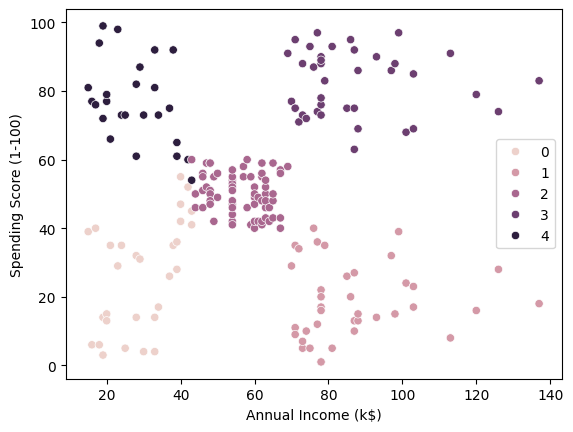

In [21]:
sns.scatterplot(x=df['Annual Income (k$)'], y=df['Spending Score (1-100)'], hue=point)

Сделаем то-же самое в sklern

In [22]:
df_id_out = df_encoded.drop(['CustomerID'], axis=1)
df_an_sp = df_encoded[['Annual Income (k$)', 'Spending Score (1-100)']]

# сократим количество данных до ['Annual Income (k$)', 'Spending Score (1-100)'] и 30 строк
x = df_an_sp.iloc[:10, :2]
x

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40
5,17,76
6,18,6
7,18,94
8,19,3
9,19,72


In [23]:
km = KMeans(n_clusters=5)
x = x

km.fit(x)

points = km.predict(x)

<Axes: xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

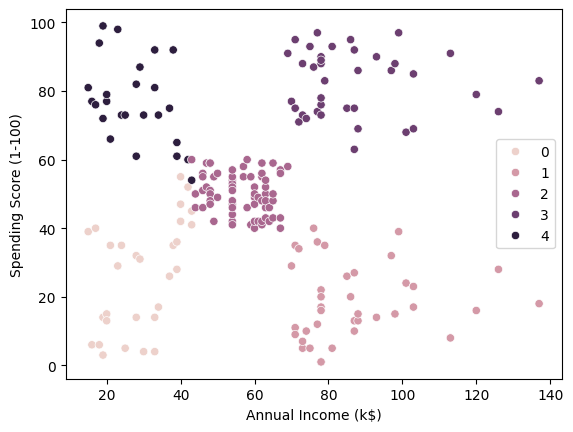

In [24]:
sns.scatterplot(x=df['Annual Income (k$)'], y=df['Spending Score (1-100)'], hue=point)

Сделаем кластеризацию в sklearn на всех преобразованных признаках кроме id

df_id_out

In [25]:
km = KMeans(n_clusters=5)
x = df_id_out

km.fit(x)

points = km.predict(x)

<Axes: xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

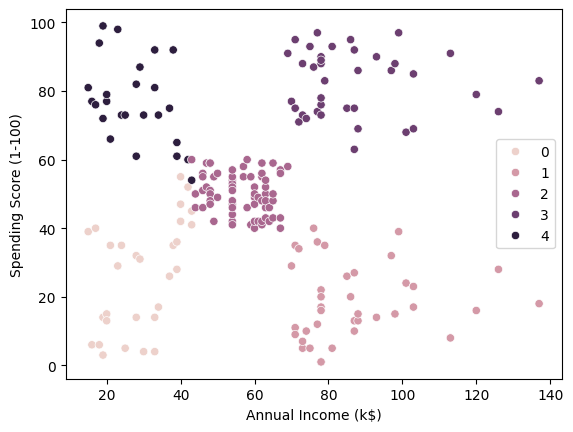

In [26]:
sns.scatterplot(x=df['Annual Income (k$)'], y=df['Spending Score (1-100)'], hue=point)

#### Метод локтя

<Axes: >

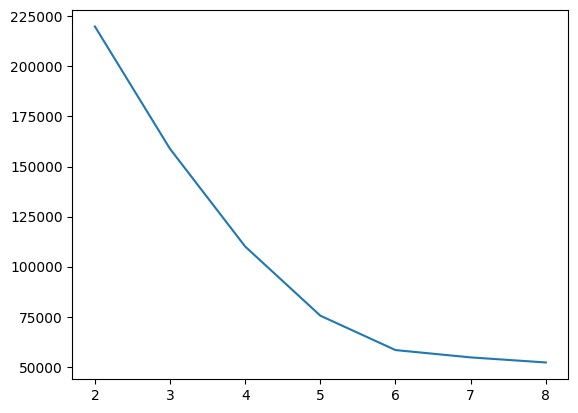

In [27]:
n_clusters = list(range(2, 9))
x = df_id_out
metrics = []

for k in n_clusters:
  km = KMeans(n_clusters=k).fit(x)
  metrics.append(km.inertia_)

sns.lineplot(x=n_clusters, y=metrics)

### Задание 5

Постройте финальную модель кластеризации с количеством кластеров, опредёленным в предыдущем задании.

In [28]:
df.columns

Index(['CustomerID', 'Genre', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

In [29]:
km = KMeans(n_clusters=4)
x = df_id_out

km.fit(x)

points = km.predict(x)

<Axes: xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

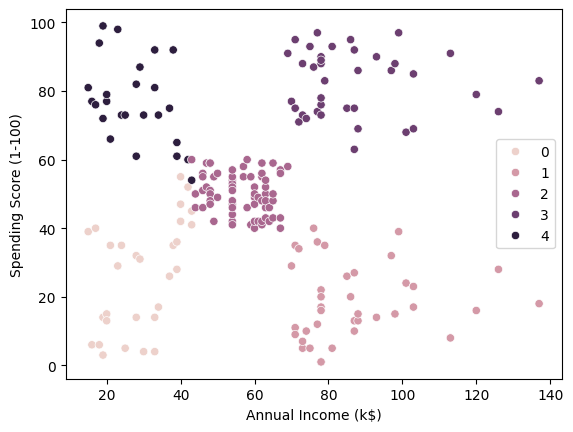

In [30]:
sns.scatterplot(x=df['Annual Income (k$)'], y=df['Spending Score (1-100)'], hue=point)

### Задание 6 (выполните по желанию)

При работе с данными важно не только качество моделей машинного обучения, но и интерпретация полученных результатов и представление их в виде, понятном пользователям и заказчикам.

После построения модели кластеризации вы разбили покупателей на группы. Теперь важно интерпретировать эти группы, то есть создать профиль группы. 

В качестве профиля группы часто используют её типичного представителя. В кластерах типичным представителем можно назвать центроиду кластера. В sklearn получить список центроид можно с помощью атрибута `cluster_centers_` у объекта класса KMeans (этот атрибут возвращает матрицу с размерностями (количество кластеров, количество признаков), подробнее об этом [в материале](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)). 

Получите центроиды кластеров, преобразуйте их к датафрейму, опишите типичного представителя каждой группы и чем группы отличаются друг от друга. При описании и сравнении используйте методы визуализации.

In [31]:
# Получаем центроиды кластеров
centroids = km.cluster_centers_

#### Посмотрим сначала центроиды по признаку пола

In [32]:
# Преобразуем центроиды в DataFrame
centroids_df = pd.DataFrame(centroids, columns=['Genre', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'])  
centroids_df.index.name = 'Cluster'

In [33]:
# Например, получаем центроиды (пример)
df_to_interprit = df_to_interprit.drop(['CustomerID'], axis=1)
centroids = df_to_interprit.groupby('Genre').mean()

# Получаем 'Genre' как моду
genres = df.groupby('Genre')['Genre'].agg(lambda x: x.mode()[0])

# Объединяем результаты
centroids_df = pd.DataFrame(centroids).join(genres)

centroids_df.index.name = 'Cluster'
print(centroids_df)

               Age  Annual Income (k$)  Spending Score (1-100)   Genre
Cluster                                                               
Female   38.098214           59.250000               51.526786  Female
Male     39.806818           62.227273               48.511364    Male


In [34]:
# Посмотрим на центроиды
print(centroids_df)

               Age  Annual Income (k$)  Spending Score (1-100)   Genre
Cluster                                                               
Female   38.098214           59.250000               51.526786  Female
Male     39.806818           62.227273               48.511364    Male


In [35]:
# Описываем типичного представителя каждой группы
for idx, row in centroids_df.iterrows():
    print(f"Кластер {idx}:")
    print(f"  Genre: {row['Genre']}, Age: {row['Age']}, Annual Income (k$): {row['Annual Income (k$)']}, Spending Score (1-100): {row['Spending Score (1-100)']}")  
    print()


Кластер Female:
  Genre: Female, Age: 38.098214285714285, Annual Income (k$): 59.25, Spending Score (1-100): 51.526785714285715

Кластер Male:
  Genre: Male, Age: 39.80681818181818, Annual Income (k$): 62.22727272727273, Spending Score (1-100): 48.51136363636363



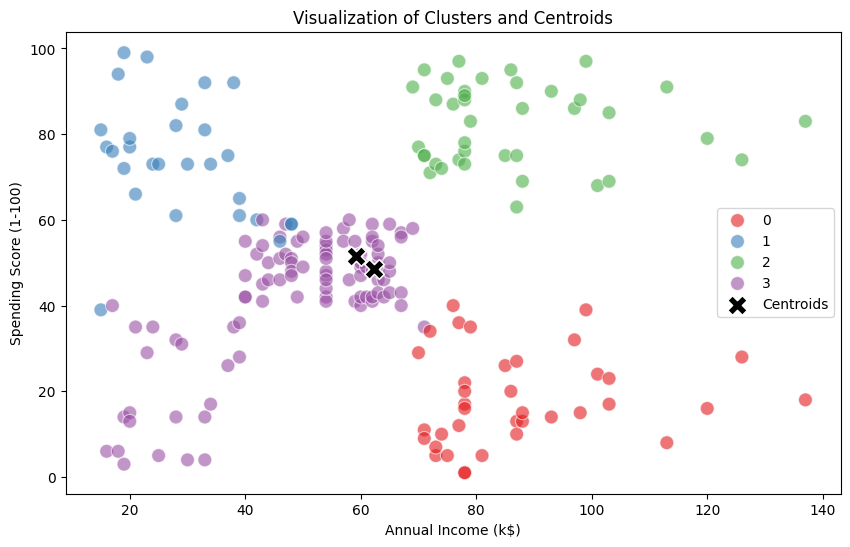

In [36]:
# Визуализация центроидов кластеров
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue=km.labels_, palette='Set1', alpha=0.6, s=100)
sns.scatterplot(data=centroids_df, x='Annual Income (k$)', y='Spending Score (1-100)', color='black', marker='X', s=200, label='Centroids')
plt.title('Visualization of Clusters and Centroids')
plt.legend()
plt.show()

#### Посмотрим центроиды по всем признакам

In [37]:
# Получение центроидов
centroids = km.cluster_centers_

In [38]:
# Создание DataFrame из центроидов
centroids_df = pd.DataFrame(centroids, columns=df_id_out.columns)

In [39]:
# Восстановим значения оригинального признака Genre с использованием порога
# учитывая что мы имеем УСРЕДНЕННОЕ значение Genre
centroids_df['Genre'] = np.where(centroids_df['Genre_Male'] > 0.5, 'Male', 'Female')

In [40]:
# Удаление колонки Genre_Male и округление значений до 2-х знаков
centroids_df = centroids_df.drop(columns=['Genre_Male']).round(2)
print(centroids_df)

     Age  Annual Income (k$)  Spending Score (1-100)   Genre
0  40.32               87.43                   18.19    Male
1  24.82               28.71                   74.25  Female
2  32.69               86.54                   82.13  Female
3  44.87               48.94                   42.55  Female


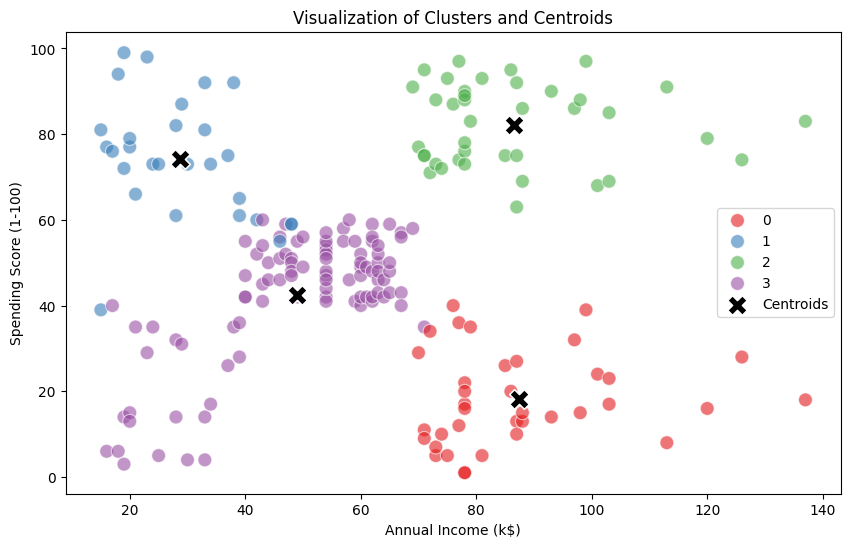

In [41]:
# Визуализация центроидов кластеров
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue=km.labels_, palette='Set1', alpha=0.6, s=100)
sns.scatterplot(data=centroids_df, x='Annual Income (k$)', y='Spending Score (1-100)', color='black', marker='X', s=200, label='Centroids')
plt.title('Visualization of Clusters and Centroids')
plt.legend()
plt.show()

#### Опишием типичных представителей кластера

Учитывая изломы в методе локтя:

<Axes: >

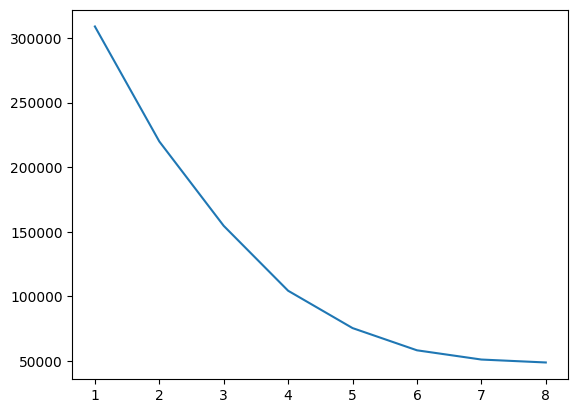

In [42]:
n_clusters = list(range(1, 9))
x = df_id_out
metrics = []

for k in n_clusters:
  km = KMeans(n_clusters=k).fit(x)
  metrics.append(km.inertia_)

sns.lineplot(x=n_clusters, y=metrics)

Мы посмотрим типичных представителей классов для 3-х, 4-х и заодно для пяти и шести кластеров 

поскольку явного и резкого излома на графике мы ненаблюдаем

In [43]:
#для трех кластеров

#     Age  Annual Income (k$)  Spending Score (1-100)   Genre
#0  40.33               44.15                   49.83  Female
#1  32.69               86.54                   82.13  Female
#2  40.39               87.00                   18.63    Male

In [44]:
#для четырех кластеров

#     Age  Annual Income (k$)  Spending Score (1-100)   Genre
#0  44.77               48.64                   42.81  Female
#1  32.69               86.54                   82.13  Female
#2  40.39               87.00                   18.63    Male
#3  24.52               28.22                   74.78  Female

In [45]:
#для пяти кластеров

#Age  Annual Income (k$)  Spending Score (1-100)   Genre
#0  33.35               57.70                   49.00  Female
#1  32.69               86.54                   82.13  Female
#2  41.65               88.74                   16.76    Male
#3  25.00               25.26                   77.61  Female
#4  54.06               40.46                   36.72  Female

In [46]:
# для шести кластеров

#     Age  Annual Income (k$)  Spending Score (1-100)   Genre
#0  44.14               25.14                   19.52  Female
#1  32.69               86.54                   82.13  Female
#2  41.65               88.74                   16.76    Male
#3  25.27               25.73                   79.36  Female
#4  56.16               53.38                   49.09  Female
#5  27.41               57.03                   48.77  Female

In [47]:
print(centroids_df)

     Age  Annual Income (k$)  Spending Score (1-100)   Genre
0  40.32               87.43                   18.19    Male
1  24.82               28.71                   74.25  Female
2  32.69               86.54                   82.13  Female
3  44.87               48.94                   42.55  Female


In [48]:
# для удобства выведем медианные значения признаков
print('годовой доход покупателя, медиана:', df['Annual Income (k$)'].median())
print('рейтинг трат покупателя, медиана:', df['Spending Score (1-100)'].median())

print('годовой доход покупателя, среднее:', df['Annual Income (k$)'].mean())
print('рейтинг трат покупателя, среднее:', df['Spending Score (1-100)'].mean())

годовой доход покупателя, медиана: 61.5
рейтинг трат покупателя, медиана: 50.0
годовой доход покупателя, среднее: 60.56
рейтинг трат покупателя, среднее: 50.2


#### пожалуй выберем вариант с разбиением на 4 кластера

#### поскольку у нас образовались похожие классы, для более детального разбиения можно воспользоваться 6-ю кластерами

и соответственно получим следующее:

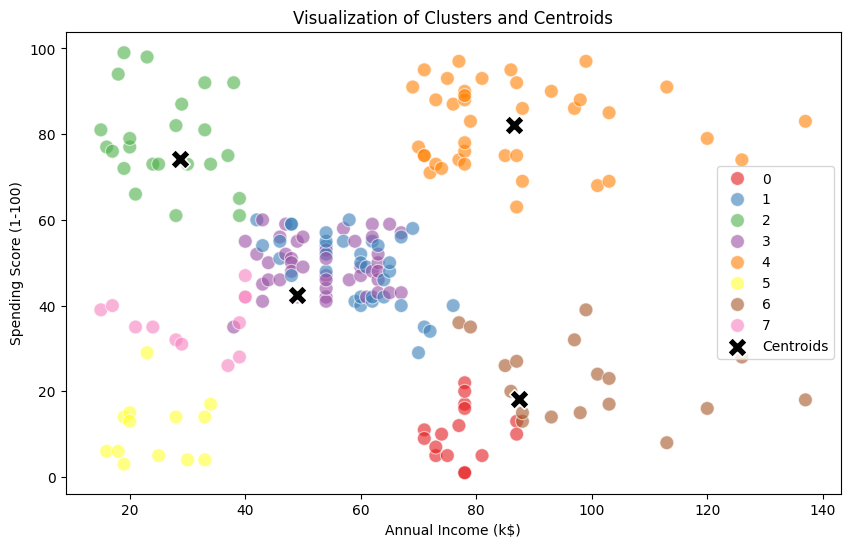

In [49]:
# Визуализация центроидов кластеров
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue=km.labels_, palette='Set1', alpha=0.6, s=100)
sns.scatterplot(data=centroids_df, x='Annual Income (k$)', y='Spending Score (1-100)', color='black', marker='X', s=200, label='Centroids')
plt.title('Visualization of Clusters and Centroids')
plt.legend()
plt.show()

кластер 0:

возраст: 44-45 лет, 

годовой доход: ниже среднего,  

рейтинг трат: ниже среднего, 

Female

In [50]:
#####

кластер 1:

возраст: 32-33 года, 

годовой доход: выше среднего,  

рейтинг трат: выше среднего, 

Female

In [51]:
#####

кластер 2:

возраст: 40-41 год, 

годовой доход: выше среднего,  

рейтинг трат: значительно меньше среднего, 

Male

In [52]:
#####

кластер 3:

возраст: 24-25 лет, 

годовой доход: существенно ниже среднего,  

рейтинг трат: значительно выше среднего, 

Female